<a href="https://colab.research.google.com/github/Loinen/geodata_analysis/blob/main/lab2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# for colab
# ! pip install statsmodels --upgrade

     |████████████████████████████████| 9.5MB 6.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.ar_model import AutoReg
from math import sqrt
from statsmodels.tsa.ar_model import ar_select_order

    TEMP - Mean temperature (.1 Fahrenheit)
    SLP - Mean sea level pressure for the day in millibars to tenths. Missing = 9999.9 (.1 mb)
    WDSP – Mean wind speed (.1 knots)

In [2]:
random.seed(42)
original_data = pd.read_csv("https://raw.githubusercontent.com/Loinen/geodata_analysis/main/data/data_spb.csv", index_col=1, na_values='NA', usecols=['STATION', 'DATE', 'TEMP', 'SLP', 'WDSP'])
original_data

,STATION,SLP,TEMP,WDSP
DATE,,,,
1990-02-03,26060099999,1010.5,34.3,999.9
1990-02-13,26060099999,1002.7,31.8,5.8
1990-04-29,26060099999,1014.9,50.4,7.8
1990-01-01,26063099999,1020.3,27.5,7.0
1990-01-02,26063099999,1020.4,22.2,3.6
...,...,...,...,...
2019-12-31,26072099999,993.5,35.8,5.1
2020-01-01,26063099999,9999.9,33.1,9.1
2020-01-02,26063099999,9999.9,38.7,11.0


In [3]:
original_data = original_data.loc[original_data.STATION == 26063099999]
original_data = original_data.drop(columns='STATION')

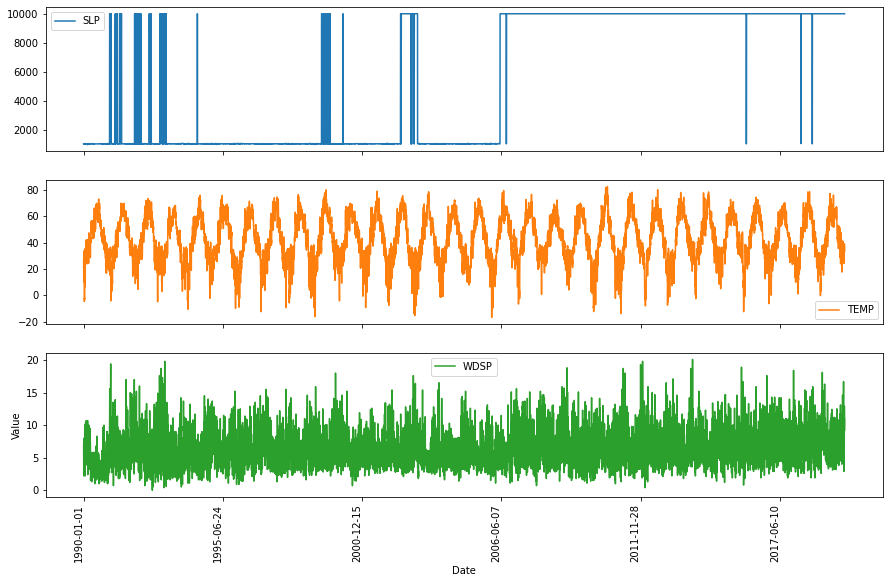

In [4]:
original_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()
# we can see a lot of gaps at the end

In [5]:
# удаление пропущенных значений + убираем все после 2006 года
original_data = original_data.loc[:'2006-01-01']

data = original_data.copy()
missing_vals = data.loc[data.SLP==9999.9]
data = data.replace(9999.9, np.nan, regex=True)
data = data.dropna(subset=['SLP'])

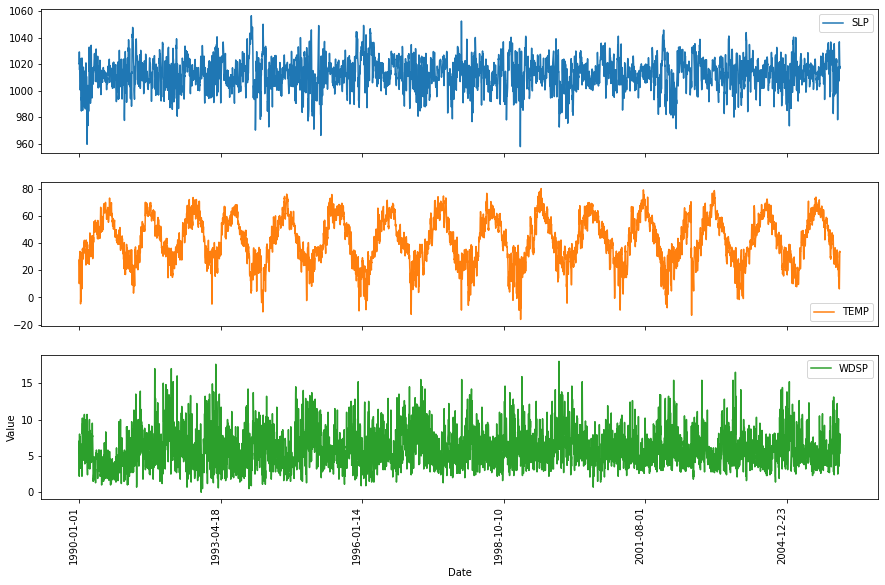

In [6]:
data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [7]:
data.shape

(5375, 3)

In [8]:
missing_vals.shape

(469, 3)

# Авторегрессия

In [9]:
pressure = data['SLP'].values

In [10]:
def autoreg(series, prediction_size, train_size, lags, trend, exog=None):
    X_train_autoreg, X_test_autoreg = series[len(series)-train_size-prediction_size:len(series)-prediction_size],\
    series[len(series)-prediction_size:]
    
    if exog is None:
        autoreg_model = AutoReg(X_train_autoreg, lags=lags, trend=trend)
        autoreg_model_fit = autoreg_model.fit()
        
        predictions = autoreg_model_fit.predict(start=len(X_train_autoreg)-1, 
                                end=len(X_test_autoreg)+len(X_train_autoreg)-2, dynamic=True)
    else:
        exog_train, exog_test = exog[len(exog)-train_size-prediction_size:len(exog)-prediction_size],\
        exog[len(exog)-prediction_size:]
        
        autoreg_model = AutoReg(X_train_autoreg, lags=lags, trend=trend, exog=exog_train)
        autoreg_model_fit = autoreg_model.fit()
        
        predictions = autoreg_model_fit.predict(start=len(X_train_autoreg)-1, 
                                end=len(X_test_autoreg)+len(X_train_autoreg)-2, dynamic=True, exog_oos=exog_test)
    
    rmse = sqrt(mean_squared_error(X_test_autoreg, predictions))
    mae = mean_absolute_error(X_test_autoreg, predictions)
    
    fig, ax = plt.subplots()

    ax.plot(X_test_autoreg, label="Test")
    ax.plot(predictions, label="Prediction")

    ax.legend()
    plt.show()
    
    print("rmse", rmse)
    print("mae", mae)
    
    return predictions

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


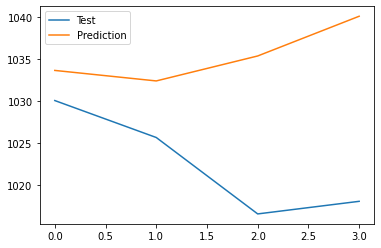

rmse 14.98063414700986
mae 12.792355783383073


In [11]:
prediction_size = 4
predictions_5_points = autoreg(pressure, prediction_size, 10, 3, 'n')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


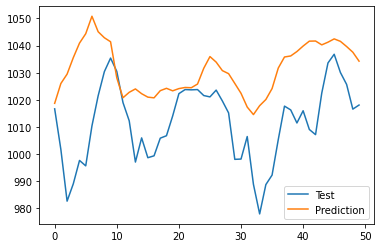

rmse 23.315749689339068
mae 19.457385276243723


In [12]:
prediction_size = 50
predictions_5_points = autoreg(pressure, prediction_size, 100, 26, 'ct')

In [13]:
prediction_size = 4
predictions_5_points = autoreg(pressure, prediction_size, 10, 3, 'n', exog=temp) # pressure?

NameError: ignored

In [14]:
prediction_size = 100
predictions_5_points = autoreg(pressure, prediction_size, 100, 24, 'ct', exog=temp)

NameError: ignored

In [15]:
prediction_size = 100
predictions_5_points = autoreg(pressure, prediction_size, 150, 40, 'ct', exog=temp)

NameError: ignored

# Вариант с 1 семестра (линейная регрессия)

Mean absolute error =  8.313310354591888
Mean squared error =  113.1030017506143


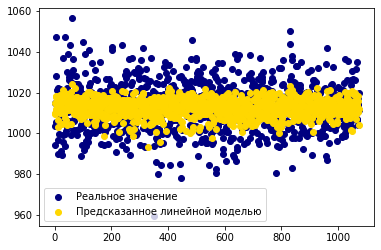

In [16]:
X = data[['WDSP', 'TEMP']]
y = data[['SLP']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

model = LinearRegression(normalize=True).fit(X_train,y_train)
predicted_del = model.predict(X_test)
predicted_del

mae = mean_absolute_error(y_test, predicted_del)
mse = mean_squared_error(y_test, predicted_del)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

x = range(len(y_test))
plt.scatter(x, y_test, color='navy', label=u'Реальное значение')
plt.scatter(x, predicted_del, color='gold', label=u'Предсказанное линейной моделью')
plt.legend()
plt.show()

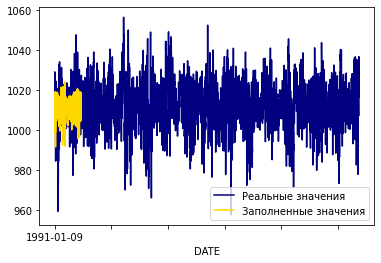

In [17]:
# заполнение пропусков лин регрессией
X_miss = missing_vals[['WDSP', 'TEMP']]
y_pred = model.predict(X_miss)

missing_vals['SLP'] = y_pred

data['SLP'].plot(color='navy', label='Реальные значения')
missing_vals['SLP'].plot(color='gold', label='Заполненные значения')
plt.legend()

In [18]:
train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

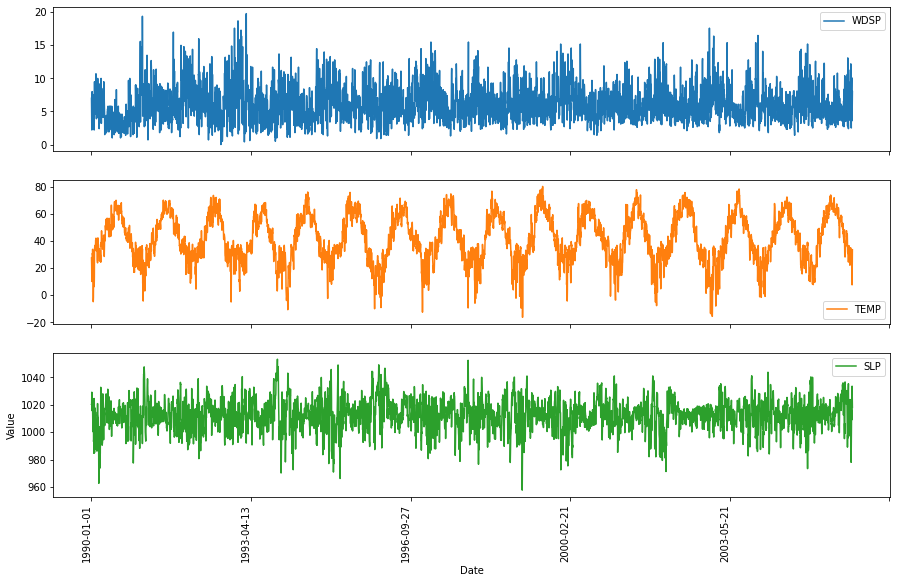

In [19]:
filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [21]:
model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)

In [22]:
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse) 

Mean absolute error =  8.31331035459188
Mean squared error =  113.10300175061406


# Медиана

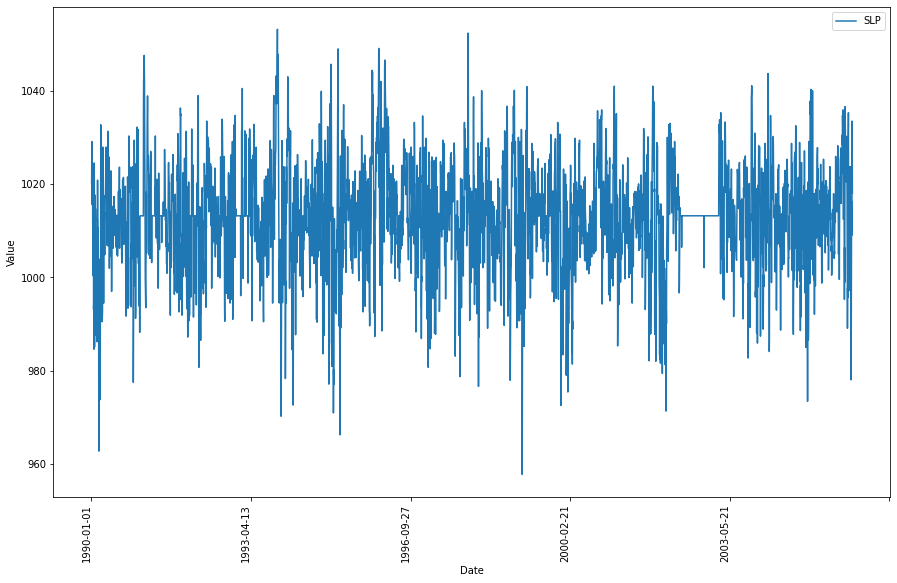

Mean absolute error =  8.293829557237592
Mean squared error =  112.76744765270716


In [126]:
missing_vals['SLP'] = train['SLP'].median()

train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data['SLP'].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


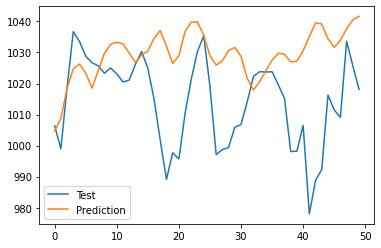

rmse 21.945723490558443
mae 16.89276424136738


In [127]:
pressure = filled_data['SLP'].values
prediction_size = 50
predictions_5_points = autoreg(pressure, prediction_size, 100, 26, 'ct')

# Линейная интерполяция (проверка на рандомных пропусках)

100 (500, 3)


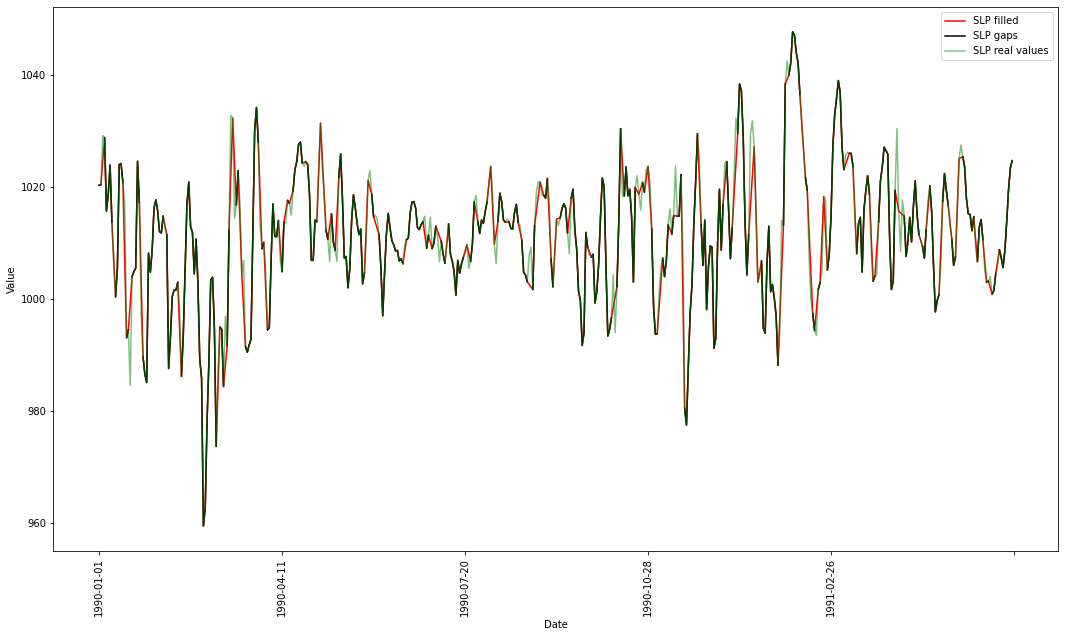

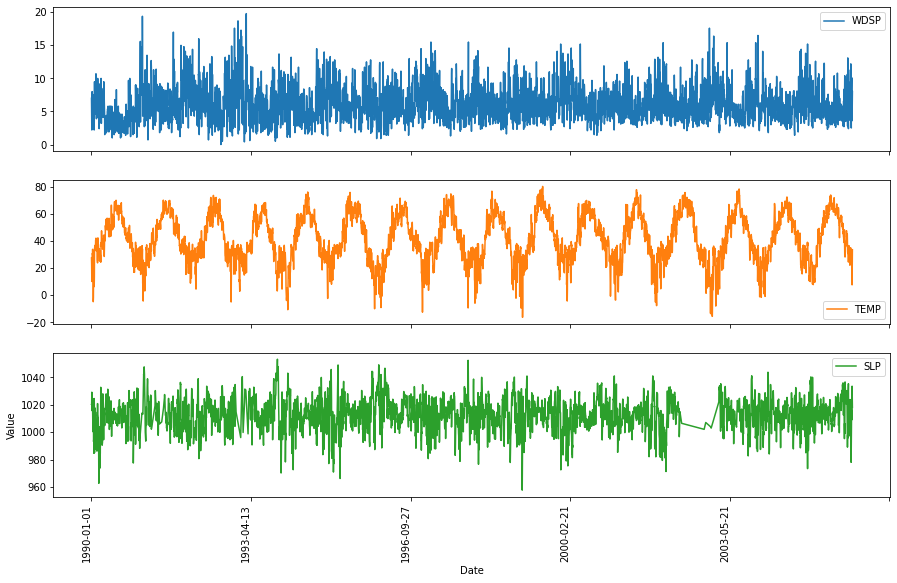

Mean absolute error =  8.300717034195577
Mean squared error =  113.03582283661282


In [122]:
missing_nan = original_data.copy()
missing_nan = missing_nan.replace(9999.9, np.nan, regex=True)

random_missing = data.copy()
random_missing = random_missing[:500]
n_missing = int(random_missing.SLP.size/5) 
print(n_missing, random_missing.shape)
random_idx = np.random.choice(random_missing.index, n_missing, replace=False)
random_missing.at[random_idx, "SLP"] = np.nan
random_missing = random_missing.sort_index()

filled = random_missing.copy()
filled['SLP'] = filled[['SLP']].interpolate(method='linear')['SLP']

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

missing_interpolate = missing_nan[['SLP']].interpolate(method='linear')['SLP']
missing_vals['SLP'] = missing_interpolate

train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


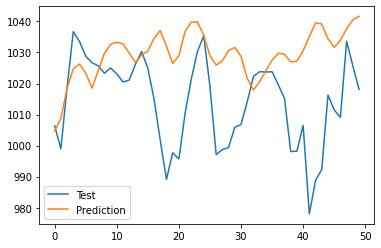

rmse 21.945723490558443
mae 16.89276424136738


In [123]:
pressure = filled_data['SLP'].values
prediction_size = 50
predictions_5_points = autoreg(pressure, prediction_size, 100, 26, 'ct')

# Интерполяция сплайнами

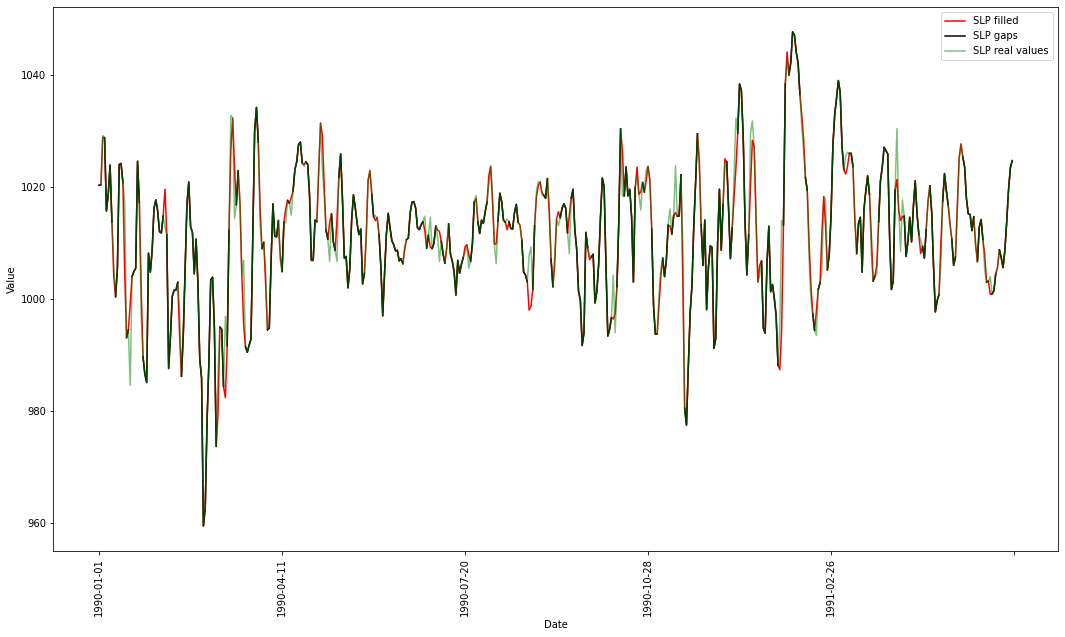

In [128]:
s = pd.Series(random_missing["SLP"].values)
filled['SLP'] = s.interpolate(method='spline', order=3).values

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [129]:
missing_spline = missing_nan.copy()
s = pd.Series(missing_spline["SLP"].values)

missing_spline['SLP'] = s.interpolate(method='spline', order=3).values
missing_vals['SLP'] = missing_spline

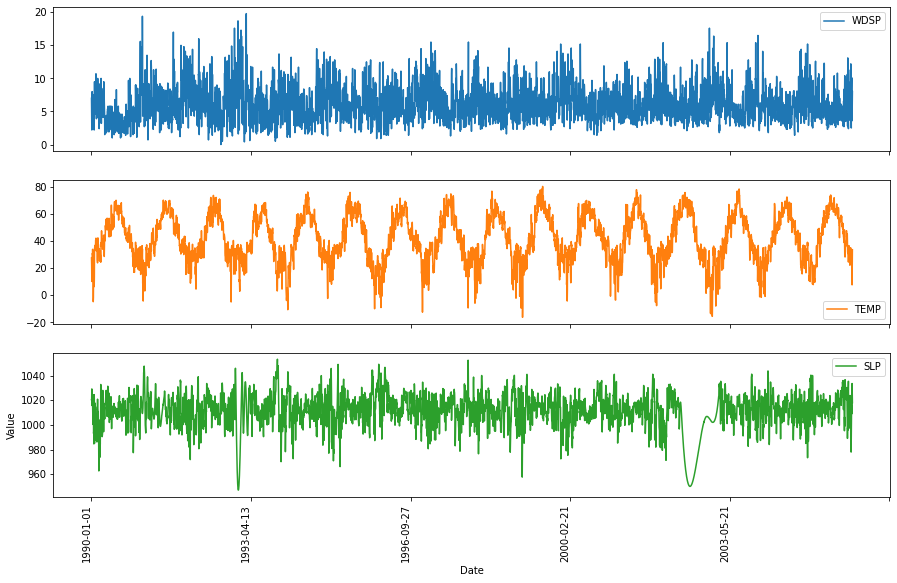

Mean absolute error =  8.490055469025432
Mean squared error =  116.48842739609739


In [130]:
train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


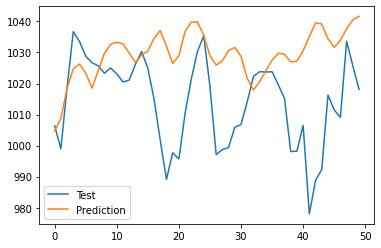

rmse 21.945723490558443
mae 16.89276424136738


In [131]:
pressure = filled_data['SLP'].values
prediction_size = 50
predictions_5_points = autoreg(pressure, prediction_size, 100, 26, 'ct')